In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit
from tied_utils import simulated_tied_ddm_norm, tied_data_gen_wrapper, rho_E_minus_small_t_NORM_TIED_fn
from scipy.integrate import quad
from pyvbmc import VBMC
import corner
import random
from tqdm import tqdm

from tied_utils import tied_abs_units_decay, prob_of_hitting_up_in_norm_units

# params

In [2]:
# Stim params
ILD_arr = [-6, -3, 0, 3, 6]
ABL_arr = [20, 40, 60]


t_non_decision = 0.02
rate_lambda = 0.1
T_0 = 0.9 * 1e-3
theta_E = 100
dt = 1e-4
c = 0.1
c1 = 0.01

# # Model params
# rate_lambda = 0.076
# theta_E = 50.7
# T_0 = 0.19*(1e-3)
# t_non_decision = 78*(1e-3)

# sim params
N_sim = int(40e3)
dt = 1e-4

# fitting params
K_max = 10

# gen data

In [3]:
sim_results = Parallel(n_jobs=-1)(delayed(tied_abs_units_decay)(ILD_arr, ABL_arr, rate_lambda, theta_E, T_0, t_non_decision, dt, c, c1) for _ in range(N_sim))

In [4]:
# remove elements if 'choice' is none
sim_results = [x for x in sim_results if x['choice'] is not None]
print(f"Number of valid simulations: {len(sim_results)}")

Number of valid simulations: 20994


len of all_rts = 20994


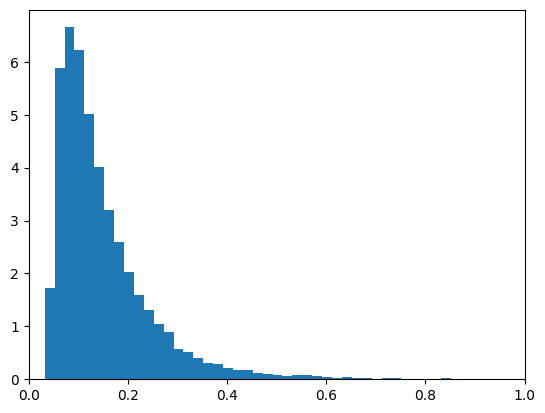

In [5]:
all_rts = [res['rt'] for res in sim_results if res['rt'] is not np.nan] 
plt.hist(all_rts, bins=500, density=True);
plt.xlim(0,1)
print(f'len of all_rts = {len(all_rts)}')

In [6]:
# sim_results = Parallel(n_jobs=-1)(delayed(tied_data_gen_wrapper)(ILD_arr, ABL_arr, rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

# loglike fn

In [7]:
def compute_loglike(res, rate_lambda, theta_E, T_0, t_non_decision, c, c1):
    ILD = res['ILD']
    ABL = res['ABL']
    choice = res['choice']
    rt = res['rt']

    omega = (2 / (T_0 * (theta_E**2))) * (10**( (rate_lambda * ABL) / 20))
    dtau_by_dt = omega * (1/c)*np.exp( -( rt-t_non_decision ) / c ) + c1

    if choice == 1:
        prob = prob_of_hitting_up_in_norm_units(rt, ILD, rate_lambda, theta_E, t_non_decision, omega, c, c1, dtau_by_dt)
    elif choice == -1:
        prob = prob_of_hitting_up_in_norm_units(rt, ILD, rate_lambda, -theta_E, t_non_decision, omega, c, c1, dtau_by_dt)
    log_prob = np.log(prob)
    if np.isnan(log_prob):
        # print(f'nan loglike at params = {[rate_lambda, theta_E, T_0, t_non_decision]} for res = {res}')
        return np.log(1e-50)

    if np.isinf(log_prob):
        # print(f'inf loglike at params = {[rate_lambda, theta_E, T_0, t_non_decision]} for res = {res}')
        return np.log(1e-50)

    return log_prob

def tied_loglike_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision, c, c1 = params

    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(res, rate_lambda, theta_E, T_0, t_non_decision, c, c1) for res in sim_results)
    loglike = np.sum(all_loglike)

    return loglike

# Bounds

In [8]:
rate_lambda_bounds = [0.01, 0.2]
theta_E_bounds = [50, 150]
T_0_bounds = [0.1*(1e-3), 1.2*(1e-3)]
t_non_decision_bounds = [0*(1e-3), 50*(1e-3)]
c_bounds = [0.01, 0.5]
c1_bounds = [0, 0.5]

rate_lambda_plausible_bounds = [0.05, 0.15]
theta_E_plausible_bounds = [80, 120]
T_0_plausible_bounds = [0.7*(1e-3), 1*(1e-3)]
t_non_decision_plausible_bounds = [10*(1e-3), 30*(1e-3)]
c_plausible_bounds = [0.05, 0.3]
c1_plausible_bounds = [0.005, 0.1]

# True params
# rate_lambda = 0.076
# theta_E = 50.7
# T_0 = 0.19*(1e-3)
# t_non_decision = 78*(1e-3)

# Prior

In [9]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def tied_prior_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision, c, c1 = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], \
                                            rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], \
                                            theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], \
                                            T_0_plausible_bounds[1], T_0_bounds[1])
    t_non_decision_logpdf = trapezoidal_logpdf(t_non_decision, t_non_decision_bounds[0], t_non_decision_plausible_bounds[0], \
                                            t_non_decision_plausible_bounds[1], t_non_decision_bounds[1])
    
    c_logpdf = trapezoidal_logpdf(c, c_bounds[0], c_plausible_bounds[0], \
                                            c_plausible_bounds[1], c_bounds[1])
    
    c1_logpdf = trapezoidal_logpdf(c1, c1_bounds[0], c1_plausible_bounds[0], \
                                            c1_plausible_bounds[1], c1_bounds[1])
    
    return rate_lambda_logpdf + theta_E_logpdf + T_0_logpdf + t_non_decision_logpdf + c_logpdf + c1_logpdf

# prior + likelihood

In [10]:
def tied_joint_fn(params):
    return tied_loglike_fn(params) + tied_prior_fn(params)

# run vbmc

In [11]:
lb = np.array([rate_lambda_bounds[0], theta_E_bounds[0], T_0_bounds[0], t_non_decision_bounds[0], c_bounds[0], c1_bounds[0]])
ub = np.array([rate_lambda_bounds[1], theta_E_bounds[1], T_0_bounds[1], t_non_decision_bounds[1], c_bounds[1], c1_bounds[1]])
plb = np.array([rate_lambda_plausible_bounds[0], theta_E_plausible_bounds[0], T_0_plausible_bounds[0], \
                  t_non_decision_plausible_bounds[0], c_plausible_bounds[0], c1_plausible_bounds[0]])
pub = np.array([rate_lambda_plausible_bounds[1], theta_E_plausible_bounds[1], T_0_plausible_bounds[1], \
                t_non_decision_plausible_bounds[1], c_plausible_bounds[1], c1_plausible_bounds[1]])

np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
t_non_decision_0 = np.random.uniform(t_non_decision_plausible_bounds[0], t_non_decision_plausible_bounds[1])
c_0 = np.random.uniform(c_plausible_bounds[0], c_plausible_bounds[1])
c1_0 = np.random.uniform(c1_plausible_bounds[0], c1_plausible_bounds[1])

x0 = np.array([rate_lambda_0, theta_E_0, T_0_0, t_non_decision_0, c_0, c1_0])

vbmc = VBMC(tied_joint_fn, x0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 6).
Reshaping upper bounds to (1, 6).
Reshaping plausible lower bounds to (1, 6).
Reshaping plausible upper bounds to (1, 6).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10      -79488.60     11214.01          inf        2        inf     start warm-up
     1         15      -28275.60      6173.95     11491.55        2        inf     
     2         20       -9497.90      3858.91     38044.11        2   5.93e+05     
     3         25       -7303.18      8439.05     24496.91        2   3.69e+05     


/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log

     4         30      -12554.34      4172.71     21687.78        2   3.27e+05     
     5         35       -9341.41      2209.40      7539.28        2   1.21e+05     
     6         40       -9735.44       911.07       968.79        2   1.75e+04     


/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log

     7         45       -7078.13      1504.43      3864.39        2   6.65e+04     
     8         50       -7469.15      1090.10       994.10        2   1.85e+04     


/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log


     9         55       -5957.10      3121.06     46447.66        2   6.48e+05     
    10         60       -6874.05       994.34    726416.75        2   9.89e+06     
    11         65       -7199.98       851.28     72235.02        2   9.87e+05     
    12         70       -5434.02      5574.52     16723.35        2   2.52e+05     
    13         75       -7011.18        13.20     12332.78        2   1.73e+05     
    14         80       -6845.36        86.40       496.41        2    7.6e+03     
    15         85       -6647.79       423.95       916.49        2   1.45e+04     
    16         90       -6180.59      1911.37      7512.61        2    1.1e+05     
    17         95       -6635.33        54.91      2562.15        2   3.66e+04     
    18        100       -6646.20         3.16        28.41        2        433     
    19        105       -6608.87        13.17        88.91        2   1.38e+03     
    20        110       -6593.25         2.89        19.57        2        3

/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_2645572/2230409271.py:14: RuntimeWarning: divide by zero encountered in log

    36        190       -6552.55         2.32     29103.12        2   4.11e+05     
    37        195       -6547.11         0.11        19.70        2        287     trim data
    38        200       -6546.95         0.04         0.16        2       2.79     
    39        205       -6546.98         0.03         0.04        2      0.684     
    40        210       -6546.98         0.02         0.01        2       0.19     end warm-up
    41        215       -6547.00         0.02         0.02        2       0.38     
    42        220       -6547.01         0.01         0.01        2      0.237     
    43        225       -6546.87         0.01         0.03        5      0.963     
    44        225       -6546.64         0.01         0.13        6       2.51     rotoscale
    45        230       -6546.67         0.01         0.00        7      0.164     
    46        235       -6546.65         0.01         0.01        7      0.145     
    47        240       -6546.66         0.01  

# corner

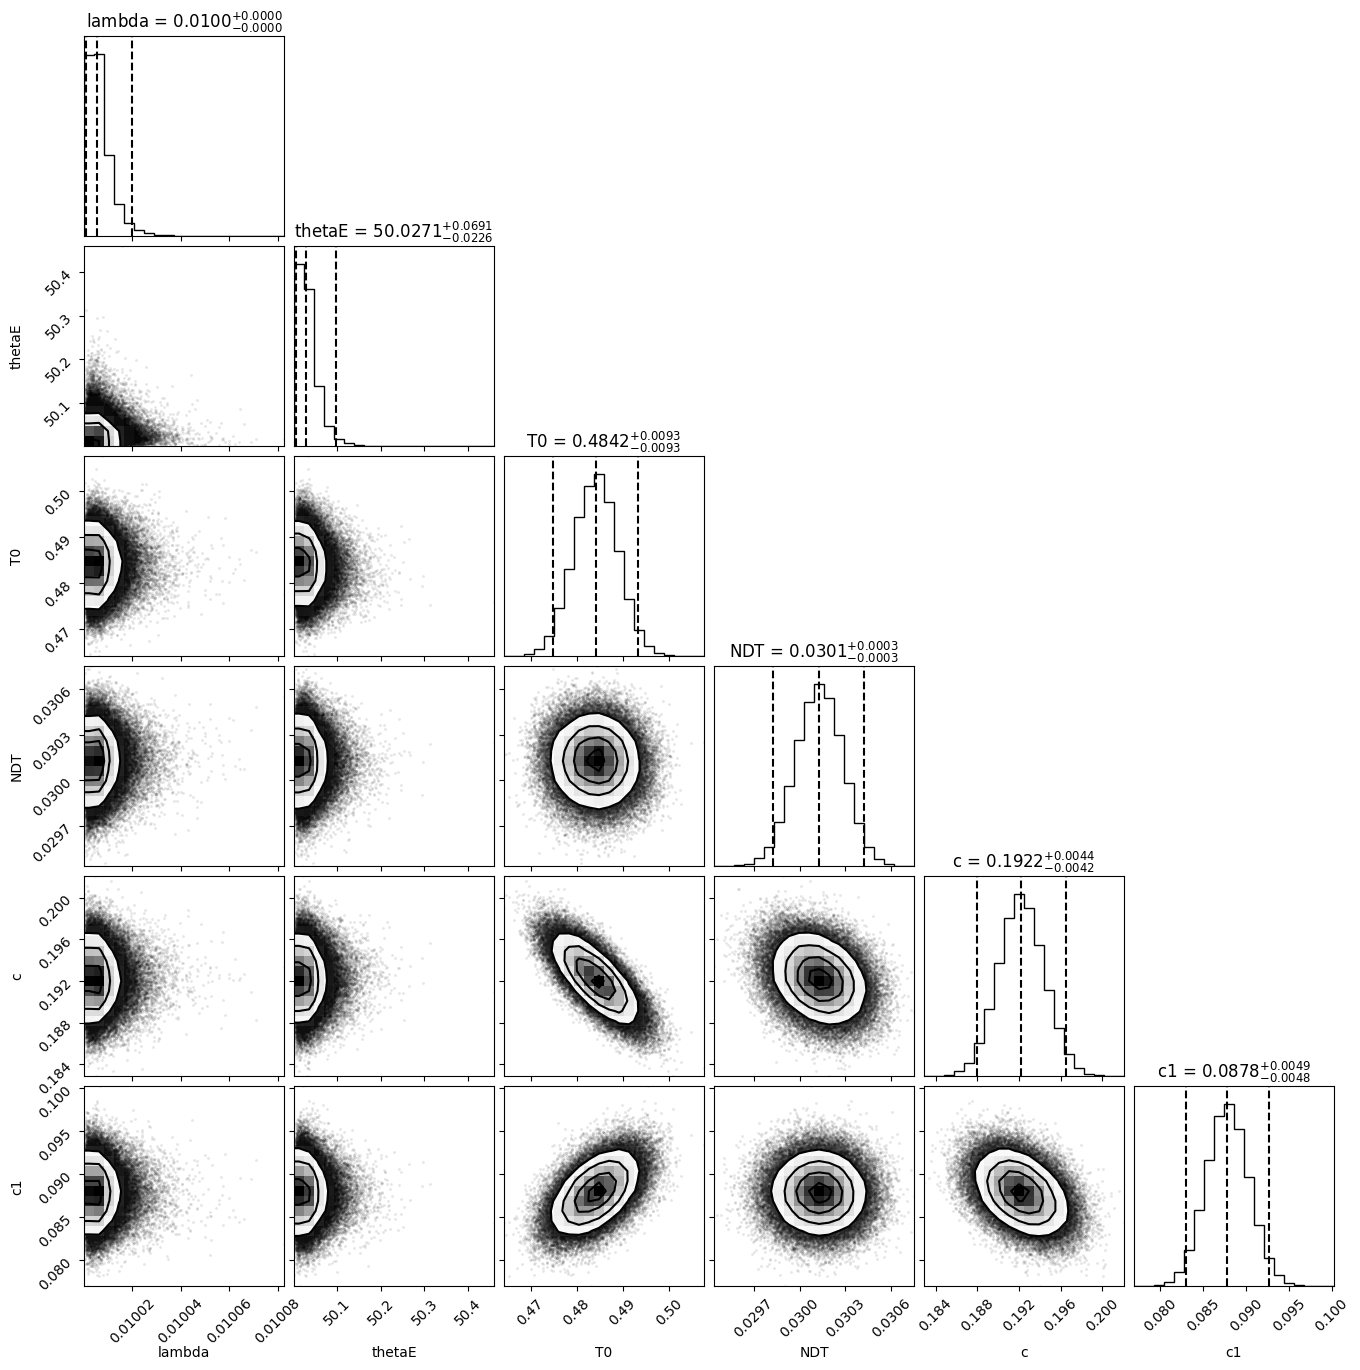

In [16]:
vp_samples = vp.sample(int(1e5))[0]

rate_lambda_samp = vp_samples[:, 0]
theta_E_samp = vp_samples[:, 1]
T_0_samp = vp_samples[:, 2]*1e3
t_non_decision_samp = vp_samples[:, 3]
c_samp = vp_samples[:, 4]
c1_samp = vp_samples[:, 5]

combined_samples = np.transpose(np.vstack((rate_lambda_samp, theta_E_samp, T_0_samp, t_non_decision_samp, c_samp, c1_samp)))
param_labels = ['lambda', 'thetaE', 'T0', 'NDT', 'c', 'c1']
true_arr = [rate_lambda, theta_E, T_0*1e3, t_non_decision, c, c1]
# corner_span = [(0.07, 0.085), (46, 55), (0.16*(1e-3), 0.25*(1e-3)), (77*(1e-3), 79*(1e-3))]

corner.corner(combined_samples, labels=param_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975], truths=true_arr, title_fmt=".4f"  );


# tachometric curves

In [15]:
mean_rate_lambda = np.mean(rate_lambda_samp)
mean_theta_E = np.mean(theta_E_samp) 
mean_T_0 = np.mean(T_0_samp)
mean_t_non_decision = np.mean(t_non_decision_samp)

median_rate_lambda = np.median(rate_lambda_samp)
median_theta_E = np.median(theta_E_samp)
median_T_0 = np.median(T_0_samp)
median_t_non_decision = np.median(t_non_decision_samp)

In [ ]:
t_pts = np.linspace(0.001, 2, 2000)

plt.figure(figsize=(15, 30))
fig_num = 1
for ILD in ILD_arr:
    for ABL in ABL_arr:
        real_up_prob = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL, rate_lambda, -theta_E, T_0, t_non_decision, K_max) for t in t_pts])
        real_down_prob = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, K_max) for t in t_pts])
        real_taco = real_up_prob/(real_up_prob + real_down_prob)

        mean_up_prob = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL, mean_rate_lambda, -mean_theta_E, mean_T_0, mean_t_non_decision, K_max) for t in t_pts])
        mean_down_prob = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL, mean_rate_lambda, mean_theta_E, mean_T_0, mean_t_non_decision, K_max) for t in t_pts])
        mean_taco = mean_up_prob/(mean_up_prob + mean_down_prob)

        median_up_prob = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL, median_rate_lambda, -median_theta_E, median_T_0, median_t_non_decision, K_max) for t in t_pts])
        median_down_prob = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL, median_rate_lambda, median_theta_E, median_T_0, median_t_non_decision, K_max) for t in t_pts])
        median_taco = median_up_prob/(median_up_prob + median_down_prob)
        
        plt.subplot(len(ILD_arr),len(ABL_arr),fig_num)
        plt.plot(t_pts, real_taco, label='Real', linestyle='-', color='b', linewidth=3);
        plt.plot(t_pts, mean_taco, label='Mean', linestyle='--', color='r',  linewidth=3);
        plt.plot(t_pts, median_taco, label='Median', linestyle='-.', color='k',  linewidth=3);
        plt.legend();
        plt.xlabel('Time (s)');plt.ylabel('up/up + down');plt.title(f'ILD = {ILD}, ABL = {ABL} Tachometric curves');

        # plt.xlim([0.1, 2])
        plt.ylim([np.nanmean(real_taco) - 1e-2, np.nanmean(real_taco) + 1e-2])

        fig_num += 1


# see likelihood of VBMC params

In [ ]:
real_loglike = tied_loglike_fn([rate_lambda, theta_E, T_0, t_non_decision])
mean_loglike = tied_loglike_fn([mean_rate_lambda, mean_theta_E, mean_T_0, mean_t_non_decision])
median_loglike = tied_loglike_fn([median_rate_lambda, median_theta_E, median_T_0, median_t_non_decision])

print(f"Real  loglike = {real_loglike:.2f}, mean loglike = {mean_loglike:.2f}, median loglike = {median_loglike:.2f}")

# distribution of samples

In [18]:
vp_samples_2 = vp.sample(int(100))[0]

In [ ]:
loglike_vp_samples = np.zeros((len(vp_samples_2)))
for i in tqdm(range(vp_samples_2.shape[0])):
    loglike_vp_samples[i] = tied_loglike_fn(vp_samples_2[i,:])

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.hist(loglike_vp_samples, alpha=0.5, label='100 VBMC samples');
plt.axvline(real_loglike, color='r', linestyle='--', label='Real loglike');
plt.axvline(mean_loglike, color='k', linestyle='-.', label='Mean params of 3M samples');
plt.axvline(median_loglike, color='b', linestyle='-', label='Median  params of 3M samples ');
plt.legend();
plt.xlabel('Loglike');plt.ylabel('Count');plt.title('Loglike distribution');
# plt.show()

# Sample selectively

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)  
plt.scatter(rate_lambda_samp, theta_E_samp, alpha=0.1, label='1e5 samples');
plt.xlabel('Rate lambda');plt.ylabel('Theta E');plt.title('Rate lambda vs Theta E');
plt.legend();

plt.subplot(1,3,2)
plt.scatter(T_0_samp, t_non_decision_samp, alpha=0.1, label='1e5 samples');
plt.xlabel('T_0');plt.ylabel('t_non_decision');plt.title('T_0 vs t_non_decision');
plt.legend();

plt.subplot(1,3,3)
plt.scatter(rate_lambda_samp, theta_E_samp, alpha=0.1, label='1e5 samples');
plt.xlabel('Rate lambda');plt.ylabel('Theta E');plt.title('Rate lambda vs Theta E');
plt.legend();


# see  in ur own sample

In [ ]:
rate_lambda_range = rate_lambda_bounds
theta_E_range = theta_E_bounds

N = 100
rate_lambda_pts = np.linspace(rate_lambda_range[0], rate_lambda_range[1], N)
theta_E_pts = np.linspace(theta_E_range[0], theta_E_range[1], N)

theta_E_reverse_pts = np.linspace(theta_E_range[1], theta_E_range[0], N)

likelihood_pts = np.zeros((N))
likelihood_reverse_pts = np.zeros((N))

for i in tqdm(range(N)):
    likelihood_pts[i] = tied_loglike_fn([rate_lambda_pts[i], theta_E_pts[i], T_0, t_non_decision])

for i in tqdm(range(N)):
    likelihood_reverse_pts[i] = tied_loglike_fn([rate_lambda_pts[i], theta_E_reverse_pts[i], T_0, t_non_decision])

In [ ]:
plt.scatter(rate_lambda_pts, theta_E_pts, c=likelihood_pts, cmap='viridis');
plt.scatter(rate_lambda_pts, theta_E_reverse_pts, c=likelihood_reverse_pts, cmap='viridis');
plt.colorbar();

plt.scatter(rate_lambda_samp, theta_E_samp, alpha=0.3, label='1e5 samples');
plt.xlabel('Rate lambda');plt.ylabel('Theta E');plt.title('Rate lambda vs Theta E');

## in ellipse

In [ ]:
vp_samples_2 = vp.sample(int(1000))[0]

rate_lambda_samp_2 = vp_samples_2[:,0]
theta_E_samp_2 = vp_samples_2[:,1]

loglikelihood_inside_ellipse = np.zeros((len(rate_lambda_samp_2)))

for i in tqdm(range(len(rate_lambda_samp_2))):
    loglikelihood_inside_ellipse[i] = tied_loglike_fn([rate_lambda_samp_2[i], theta_E_samp_2[i], T_0, t_non_decision])

In [ ]:
plt.scatter(rate_lambda_samp_2, theta_E_samp_2, c=loglikelihood_inside_ellipse, cmap='viridis');
plt.colorbar();
plt.xlabel('Rate lambda');plt.ylabel('Theta E');plt.title('Rate lambda vs Theta E');

## ellipse and X shaped points outside the ellipse

In [ ]:
rate_lambda_range = rate_lambda_bounds
theta_E_range = theta_E_bounds

N = 100
rate_lambda_pts = np.linspace(rate_lambda_range[0], rate_lambda_range[1], N)
theta_E_pts = np.linspace(theta_E_range[0], theta_E_range[1], N)

theta_E_reverse_pts = np.linspace(theta_E_range[1], theta_E_range[0], N)

likelihood_pts = np.zeros((N))
likelihood_reverse_pts = np.zeros((N))

for i in tqdm(range(N)):
    likelihood_pts[i] = tied_loglike_fn([rate_lambda_pts[i], theta_E_pts[i], T_0, t_non_decision])

for i in tqdm(range(N)):
    likelihood_reverse_pts[i] = tied_loglike_fn([rate_lambda_pts[i], theta_E_reverse_pts[i], T_0, t_non_decision])

In [ ]:
# vmin = np.min(likelihood_reverse_pts)/1e3
# vmax = np.max(loglikelihood_inside_ellipse)/1e3
vmin = -13
vmax = 13
plt.scatter(rate_lambda_pts, theta_E_pts, c=likelihood_pts/1e3, cmap='viridis', vmin=vmin, vmax=vmax);
plt.scatter(rate_lambda_pts, theta_E_reverse_pts, c=likelihood_reverse_pts/1e3, cmap='viridis', vmin=vmin, vmax=vmax);

plt.scatter(rate_lambda_samp_2, theta_E_samp_2, c=loglikelihood_inside_ellipse/1e3, cmap='viridis', vmin=vmin, vmax=vmax);

plt.colorbar();
plt.xlabel('Rate lambda');plt.ylabel('Theta E');plt.title('Rate lambda vs Theta E');

# grid and ellipse instead of x

In [115]:
theta_E_step = 1
rate_lambda_step = 0.002

theta_E_range = np.arange(46, 55, theta_E_step)  # From 46 to 54 inclusive
rate_lambda_range = np.arange(0.070, 0.085, rate_lambda_step)  # From 0.070 to 0.084 inclusive

rate_lambda_grid, theta_E_grid = np.meshgrid(rate_lambda_range, theta_E_range)

rate_lambda_pts = rate_lambda_grid.flatten()
theta_E_pts = theta_E_grid.flatten()

loglikelihood_grid = np.zeros_like(rate_lambda_pts, dtype=float)

for i in range(len(rate_lambda_pts)):
    params = [rate_lambda_pts[i], theta_E_pts[i], T_0, t_non_decision]
    loglikelihood_grid[i] = tied_loglike_fn(params)



In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(rate_lambda_pts, theta_E_pts, c=loglikelihood_grid, cmap='viridis')
plt.xlabel('rate_lambda')
plt.ylabel('theta_E')
plt.title('Log Likelihood over Parameter Grid')

# Add a colorbar to the plot
cbar = plt.colorbar(scatter, label='Log Likelihood')

# Verification: Annotate a few points to check color correspondence
# Select some indices to annotate
indices_to_annotate = np.linspace(0, len(rate_lambda_pts)-1, num=5, dtype=int)
for idx in indices_to_annotate:
    x = rate_lambda_pts[idx]
    y = theta_E_pts[idx]
    ll_value = loglikelihood_grid[idx]
    plt.annotate(f"{ll_value:.2f}", (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='black')
plt.show()



In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(theta_E_pts, rate_lambda_pts, c=loglikelihoods_grid, cmap='viridis', marker='X', s=100)
plt.colorbar(scatter, label='Log Likelihood')
plt.xlabel('theta_E')
plt.ylabel('rate_lambda')
plt.title('Log Likelihood over Parameter Grid')
plt.show()


In [ ]:
vmin = np.min([np.min(loglikelihood_inside_ellipse)/1e3, np.min(loglikelihood_grid)/1e3])
vmax = np.max([np.max(loglikelihood_inside_ellipse)/1e3, np.max(loglikelihood_grid)/1e3])

plt.scatter(rate_lambda_samp_2, theta_E_samp_2, c=loglikelihood_inside_ellipse/1e3, cmap='viridis', vmin=vmin, vmax=vmax);
scatter = plt.scatter(rate_lambda_pts, theta_E_pts, c=loglikelihood_grid/1e3, cmap='viridis', vmin=vmin, vmax=vmax, marker='X', s=100);


plt.colorbar();
plt.xlabel('Rate lambda');plt.ylabel('Theta E');plt.title('Rate lambda vs Theta E');

In [ ]:
# vmax = np.max([np.max(loglikelihood_inside_ellipse)/1e3, np.max(loglikelihood_grid)/1e3])
vmax = np.max(loglikelihood_inside_ellipse/1e3)

vmin = np.min([np.min(loglikelihood_inside_ellipse)/1e3, np.min(loglikelihood_grid)/1e3])
vmin /= vmax

plt.scatter(rate_lambda_samp_2, theta_E_samp_2, c=((loglikelihood_inside_ellipse/1e3)/vmax), cmap='viridis', vmin=vmin, vmax=1);
plt.scatter(rate_lambda_pts, theta_E_pts, c=(loglikelihood_grid/1e3)/vmax, cmap='viridis', vmin=vmin, vmax=1, marker='X', s=100);


plt.colorbar();
plt.xlabel('Rate lambda');plt.ylabel('Theta E');plt.title('Normalized by max loglike inside ellipse, Rate lambda vs Theta E');

# inside ellipse but all are samples

In [ ]:
vp_samples_2 = vp.sample(int(1000))[0]

rate_lambda_samp_2 = vp_samples_2[:,0]
theta_E_samp_2 = vp_samples_2[:,1]
T_0_samp_2 = vp_samples_2[:,2]
t_non_decision_samp_2 = vp_samples_2[:,3]

loglikelihood_inside_ellipse_all_vp = np.zeros((len(rate_lambda_samp_2)))

for i in tqdm(range(len(rate_lambda_samp_2))):
    loglikelihood_inside_ellipse_all_vp[i] = tied_loglike_fn([rate_lambda_samp_2[i], theta_E_samp_2[i], T_0_samp_2[i], t_non_decision_samp_2[i]])

In [ ]:
vmin = np.min([np.min(loglikelihood_inside_ellipse_all_vp)/1e3, np.min(loglikelihood_grid)/1e3])
vmax = np.max([np.max(loglikelihood_inside_ellipse_all_vp)/1e3, np.max(loglikelihood_grid)/1e3])

plt.scatter(rate_lambda_samp_2, theta_E_samp_2, c=loglikelihood_inside_ellipse_all_vp/1e3, cmap='viridis', vmin=vmin, vmax=vmax);
plt.scatter(rate_lambda_pts, theta_E_pts, c=loglikelihood_grid/1e3, cmap='viridis', vmin=vmin, vmax=vmax, marker='X', s=100);

plt.colorbar();

plt.xlabel('Rate lambda');plt.ylabel('Theta E');plt.title('loglike, all VP inside ellipse. Rate lambda vs Theta E');

In [ ]:
# vmax = np.max([np.max(loglikelihood_inside_ellipse_all_vp)/1e3, np.max(loglikelihood_grid)/1e3])
vmax = np.max(loglikelihood_inside_ellipse_all_vp)/1e3

vmin = np.min([np.min(loglikelihood_inside_ellipse_all_vp)/1e3, np.min(loglikelihood_grid)/1e3])
vmin /= vmax
plt.scatter(rate_lambda_samp_2, theta_E_samp_2, c=(loglikelihood_inside_ellipse_all_vp/1e3)/vmax, cmap='viridis', vmin=vmin, vmax=1);
plt.scatter(rate_lambda_pts, theta_E_pts, c=(loglikelihood_grid/1e3)/vmax, cmap='viridis', vmin=vmin, vmax=1, marker='X', s=100);

plt.colorbar();

plt.xlabel('Rate lambda');plt.ylabel('Theta E');plt.title('Normalized loglike, all VP inside ellipse. Rate lambda vs Theta E');

# Fixing NDT, and seeing in 3D

In [ ]:
vp_samples_2 = vp.sample(int(1000))[0]

rate_lambda_samp_2 = vp_samples_2[:,0]
theta_E_samp_2 = vp_samples_2[:,1]
T_0_samp_2 = vp_samples_2[:,2]

loglikelihood_inside_ellipse_3_vp = np.zeros((len(rate_lambda_samp_2)))

for i in tqdm(range(len(rate_lambda_samp_2))):
    loglikelihood_inside_ellipse_3_vp[i] = tied_loglike_fn([rate_lambda_samp_2[i], theta_E_samp_2[i], T_0_samp_2[i], t_non_decision])

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

norm = plt.Normalize(loglikelihood_inside_ellipse_3_vp.min()/1e3, loglikelihood_inside_ellipse_3_vp.max()/1e3)
colors = plt.cm.viridis(norm(loglikelihood_inside_ellipse_3_vp/1e3))

# Plot the scatter plot
scatter = ax.scatter(rate_lambda_samp_2, theta_E_samp_2, T_0_samp_2,
                     c=loglikelihood_inside_ellipse_3_vp/1e3, cmap='viridis', marker='o')

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Log Likelihood')

# Set labels
ax.set_xlabel('rate_lambda')
ax.set_ylabel('theta_E')
ax.set_zlabel('T_0')
ax.set_title('3D Scatter Plot of Parameters with Log Likelihood')

# Optionally adjust viewing angle
ax.view_init(elev=20, azim=30)  # Adjust elevation and angle as needed

plt.show()

In [ ]:
theta_E_step = 3
rate_lambda_step = 0.004
T_0_step = 0.03e-3

theta_E_range = np.arange(40, 60, theta_E_step)  # From 45 to 55 inclusive
rate_lambda_range = np.arange(0.04, 0.09, rate_lambda_step)  # From 0.070 to 0.084 inclusive
T_0_range = np.arange(0.1*(1e-3), 0.3*(1e-3), T_0_step)  # From 0.17e-3 to 0.25e-3 inclusive

theta_E_grid, rate_lambda_grid, T_0_grid = np.meshgrid(
    theta_E_range, rate_lambda_range, T_0_range, indexing='ij'
)

theta_E_pts = theta_E_grid.flatten()
rate_lambda_pts = rate_lambda_grid.flatten()
T_0_pts = T_0_grid.flatten()

likelihood_3d_grid = np.zeros_like(theta_E_pts, dtype=float)

for i in tqdm(range(len(theta_E_pts))):
    params = [rate_lambda_pts[i], theta_E_pts[i], T_0_pts[i], t_non_decision]
    likelihood_3d_grid[i] = tied_loglike_fn(params)


In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter plot with "X" shaped markers, size 100, colored by likelihood
scatter = ax.scatter(
    rate_lambda_pts, theta_E_pts, T_0_pts,
    c=likelihood_3d_grid/1e3, cmap='viridis', marker='X', s=100
)

# Add colorbar to represent the likelihood values
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Likelihood')

# Set axis labels and title
ax.set_xlabel('rate_lambda')
ax.set_ylabel('theta_E')
ax.set_zlabel('T_0')
ax.set_title('3D Scatter Plot of Parameters with Likelihood')

# Show the plot
plt.show()

In [ ]:
loglike_3d_norm = likelihood_3d_grid / 1e3
loglike_vp_norm = loglikelihood_inside_ellipse_3_vp.flatten() / 1e3

# Combine the likelihood data to compute common min and max for normalization
combined_likelihoods = np.concatenate([loglike_3d_norm, loglike_vp_norm])
combined_min = combined_likelihoods.min()
combined_max = combined_likelihoods.max()
# norm = plt.Normalize(combined_min, combined_max)
norm = plt.Normalize(0, combined_max)


# Create the figure and 3D axes
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Choose a common colormap
common_cmap = 'viridis'

# First scatter plot (likelihood_3d_grid)
scatter1 = ax.scatter(
    rate_lambda_pts, theta_E_pts, T_0_pts,
    c=loglike_3d_norm, cmap=common_cmap, norm=norm,
    marker='X', s=70, label='Likelihood Grid'
)

# Second scatter plot (loglikelihood_inside_ellipse_3_vp)
scatter2 = ax.scatter(
    rate_lambda_samp_2, theta_E_samp_2, T_0_samp_2,
    c=loglike_vp_norm, cmap=common_cmap, norm=norm,
    marker='o', s=100, label='Sampled Log Likelihood'
)

# Add a single colorbar
cbar = fig.colorbar(scatter1, ax=ax, pad=0.1)
cbar.set_label('Likelihood (x1e3)')

# Set axis labels and title
ax.set_xlabel('rate_lambda')
ax.set_ylabel('theta_E')
ax.set_zlabel('T_0')
ax.set_title('Combined 3D Scatter Plot of Parameters with Likelihood')

# Adjust viewing angle if needed
ax.view_init(elev=160, azim=30)
# ax.view_init(elev=20, azim=150)


# Add legend
ax.legend()

plt.show()


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Assuming all necessary variables are defined:
# - rate_lambda_pts, theta_E_pts, T_0_pts, likelihood_3d_grid
# - rate_lambda_samp_2, theta_E_samp_2, T_0_samp_2, loglikelihood_inside_ellipse_3_vp

# Normalize the likelihood values across both datasets
loglike_3d_norm = likelihood_3d_grid / 1e3
loglike_vp_norm = loglikelihood_inside_ellipse_3_vp.flatten() / 1e3

# Combine the likelihood data to compute common min and max for normalization
combined_likelihoods = np.concatenate([loglike_3d_norm, loglike_vp_norm])
combined_min = max(0, combined_likelihoods.min())
combined_max = combined_likelihoods.max()

# Create the first scatter plot (likelihood_3d_grid)
scatter1 = go.Scatter3d(
    x=rate_lambda_pts,
    y=theta_E_pts,
    z=T_0_pts,
    mode='markers',
    marker=dict(
        size=3,
        symbol='x',
        color=loglike_3d_norm,
        colorscale='Viridis',
        cmin=combined_min,
        cmax=combined_max,
        opacity=0.8,
        colorbar=dict(title='Likelihood (x1e3)', thickness=20),
    ),
    name='Likelihood Grid',
    showlegend=True
)

# Create the second scatter plot (loglikelihood_inside_ellipse_3_vp)
scatter2 = go.Scatter3d(
    x=rate_lambda_samp_2,
    y=theta_E_samp_2,
    z=T_0_samp_2,
    mode='markers',
    marker=dict(
        size=5,
        symbol='circle',
        color=loglike_vp_norm,
        colorscale='Viridis',
        cmin=combined_min,
        cmax=combined_max,
        opacity=0.6,
    ),
    name='Sampled Log Likelihood',
    showlegend=True
)

# Combine the plots
data = [scatter1, scatter2]

# Create the layout with increased width and height
layout = go.Layout(
    title='Combined 3D Scatter Plot of Parameters with Likelihood',
    scene=dict(
        xaxis=dict(title='rate_lambda'),
        yaxis=dict(title='theta_E'),
        zaxis=dict(title='T_0'),
    ),
    width=1000,  # Increase the width
    height=800,  # Increase the height
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()


## chose points w/o interactive libs

In [ ]:
import numpy as np
from scipy.spatial import distance_matrix

# Assuming rate_lambda_samp and theta_E_samp are numpy arrays
x = rate_lambda_samp
y = theta_E_samp

# Step 1: Compute the mean (center of the ellipse)
x_mean = np.mean(x)
y_mean = np.mean(y)

# Center the data
x_centered = x - x_mean
y_centered = y - y_mean

# Stack the centered data
data = np.vstack((x_centered, y_centered))

# Step 2: Compute covariance matrix
cov = np.cov(data)

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(cov)

# Step 3: Identify the major and minor axes
# Sort eigenvalues and eigenvectors in descending order
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# Get the major and minor axes directions
major_axis = eigvecs[:, 0]
minor_axis = eigvecs[:, 1]

# Step 4: Compute standard deviations along the axes
std_major = np.sqrt(eigvals[0])
std_minor = np.sqrt(eigvals[1])

# Decide distances along the axes
# For major axis (inside the ellipse)
s1 = std_major * 1  # 0.5 standard deviations inside the ellipse
# For minor axis (outside the ellipse)
s2 = std_minor * 5e6  # 1.5 standard deviations outside the ellipse

# Compute the positions along the axes
P1 = np.array([x_mean, y_mean]) + s1 * major_axis
P2 = np.array([x_mean, y_mean]) - s1 * major_axis
P3 = np.array([x_mean, y_mean]) + s2 * minor_axis
P4 = np.array([x_mean, y_mean]) - s2 * minor_axis

# Step 5: Find the data points closest to P1, P2, P3, P4
data_points = np.vstack((x, y)).T  # Shape (N, 2)
P = np.array([P1, P2, P3, P4])     # Shape (4, 2)

# Compute distance matrix between data points and P
dist_matrix = distance_matrix(data_points, P)  # Shape (N, 4)

# For each point in P, find the index of the closest data point
indices = np.argmin(dist_matrix, axis=0)

# Extract the corresponding data points
selected_points = data_points[indices]

# Display the selected points
print("Selected points:")
for i, point in enumerate(selected_points):
    print(f"P{i+1}: Rate lambda = {point[0]}, Theta E = {point[1]}")

plt.figure(figsize=(10, 10))
plt.scatter(rate_lambda_samp, theta_E_samp, alpha=0.1, label='1e5 samples');
plt.scatter(selected_points[0, 0], selected_points[0, 1], label='P1');
plt.scatter(selected_points[1, 0], selected_points[1, 1], label='P2');
plt.scatter(selected_points[2, 0]-0.001, selected_points[2, 1], label='P3');
plt.scatter(selected_points[3, 0]+0.001, selected_points[3, 1], label='P4');

t_major = np.linspace(-3 * std_major, 3 * std_major, 100)
x_major = x_mean + t_major * major_axis[0]
y_major = y_mean + t_major * major_axis[1]
plt.plot(x_major, y_major, 'r-', linewidth=2, label='Major Axis')

# Plot minor axis
t_minor = np.linspace(-3 * std_minor, 3 * std_minor, 100)
x_minor = x_mean + t_minor * minor_axis[0]
y_minor = y_mean + t_minor * minor_axis[1]
plt.plot(x_minor, y_minor, 'g-', linewidth=2, label='Minor Axis')



plt.xlabel('Rate lambda');plt.ylabel('Theta E');plt.title('Rate lambda vs Theta E');
plt.legend();



## define params of inside and outside

In [53]:
# plt.scatter(selected_points[0, 0], selected_points[0, 1], label='P1');
# plt.scatter(selected_points[1, 0], selected_points[1, 1], label='P2');
# plt.scatter(selected_points[2, 0]-0.001, selected_points[2, 1], label='P3');
# plt.scatter(selected_points[3, 0]+0.001, selected_points[3, 1], label='P4');

T_0_for_all = np.mean(T_0_samp)
t_non_decision_for_all = np.mean(t_non_decision_samp)

inside_param_1 = {
    'rate_lambda': selected_points[0, 0],
    'theta_E': selected_points[0, 1],
    'T_0': T_0_for_all,
    't_non_decision': t_non_decision_for_all
}

inside_param_2 = {
    'rate_lambda': selected_points[1, 0],
    'theta_E': selected_points[1, 1],
    'T_0': T_0_for_all,
    't_non_decision': t_non_decision_for_all

}


outside_param_1 = {
    'rate_lambda': selected_points[2, 0],
    'theta_E': selected_points[2, 1] - 0.001,
    'T_0': T_0_for_all,
    't_non_decision': t_non_decision_for_all
}

outside_param_2 = {
    'rate_lambda': selected_points[3, 0] + 0.001,
    'theta_E': selected_points[3, 1],
    'T_0': T_0_for_all,
    't_non_decision': t_non_decision_for_all
}

## generate data

In [ ]:
sim_data_inside_param_1 = Parallel(n_jobs=-1)(delayed(tied_data_gen_wrapper) \
(ILD_arr, ABL_arr, inside_param_1['rate_lambda'], inside_param_1['theta_E'], inside_param_1['T_0'], inside_param_1['t_non_decision'], dt) \
for _ in range(N_sim))

sim_data_inside_param_2 = Parallel(n_jobs=-1)(delayed(tied_data_gen_wrapper) \
(ILD_arr, ABL_arr, inside_param_2['rate_lambda'], inside_param_2['theta_E'], inside_param_2['T_0'], inside_param_2['t_non_decision'], dt) \
for _ in range(N_sim))  

sim_data_outside_param_1 = Parallel(n_jobs=-1)(delayed(tied_data_gen_wrapper) \
(ILD_arr, ABL_arr, outside_param_1['rate_lambda'], outside_param_1['theta_E'], outside_param_1['T_0'], outside_param_1['t_non_decision'], dt) \
for _ in range(N_sim))

sim_data_outside_param_2 = Parallel(n_jobs=-1)(delayed(tied_data_gen_wrapper) \
(ILD_arr, ABL_arr, outside_param_2['rate_lambda'], outside_param_2['theta_E'], outside_param_2['T_0'], outside_param_2['t_non_decision'], dt) \
for _ in range(N_sim))

## RT distributions

In [ ]:
plt.figure(figsize=(15, 10))
fig_num = 1
for ILD in ILD_arr:
    for ABL in ABL_arr:
        # get data of ILD and ABL from sim_data_inside_param_1
        sim_data_inside_param_1_ILD_ABL = [res['rt'] for res in sim_data_inside_param_1 if res['ILD'] == ILD and res['ABL'] == ABL]
        sim_data_inside_param_2_ILD_ABL = [res['rt'] for res in sim_data_inside_param_2 if res['ILD'] == ILD and res['ABL'] == ABL]
        sim_data_outside_param_1_ILD_ABL = [res['rt'] for res in sim_data_outside_param_1 if res['ILD'] == ILD and res['ABL'] == ABL]
        sim_data_outside_param_2_ILD_ABL = [res['rt'] for res in sim_data_outside_param_2 if res['ILD'] == ILD and res['ABL'] == ABL]

    plt.subplot(2,3,fig_num)
    plt.hist(sim_data_inside_param_1_ILD_ABL, alpha=0.3, label='Inside P1', density=True, bins=100, color='b');
    plt.hist(sim_data_inside_param_2_ILD_ABL, alpha=0.3, label='Inside P2', density=True, bins=100, color='r');
    plt.hist(sim_data_outside_param_1_ILD_ABL, alpha=0.3, label='Outside P3', density=True, bins=100, color='g');
    plt.hist(sim_data_outside_param_2_ILD_ABL, alpha=0.3, label='Outside P4', density=True, bins=100, color='k');
    plt.legend();
    plt.xlabel('RTs');plt.ylabel('Density');plt.title(f'RTs  ILD={ILD}');

    fig_num += 1

## psychometric curves

In [ ]:
plt.figure(figsize=(15, 5))
fig_num = 1
for ABL in ABL_arr:
    frac_right_vs_ILD_inside_param_1 = np.zeros((len(ILD_arr)))
    frac_right_vs_ILD_inside_param_2 = np.zeros((len(ILD_arr)))
    frac_right_vs_ILD_outside_param_1 = np.zeros((len(ILD_arr)))
    frac_right_vs_ILD_outside_param_2 = np.zeros((len(ILD_arr)))

    for ILD in ILD_arr:
        # num of choice = 1 and choic = -1 foir inside param data
        choices_ILD_ABL_inside_param_1 = [res['choice'] for res in sim_data_inside_param_1 if res['ILD'] == ILD and res['ABL'] == ABL]
        frac_right_vs_ILD_inside_param_1[ILD_arr.index(ILD)] = choices_ILD_ABL_inside_param_1.count(1)/len(choices_ILD_ABL_inside_param_1)

        choice_ILD_ABL_inside_param_2 = [res['choice'] for res in sim_data_inside_param_2 if res['ILD'] == ILD and res['ABL'] == ABL]
        frac_right_vs_ILD_inside_param_2[ILD_arr.index(ILD)] = choice_ILD_ABL_inside_param_2.count(1)/len(choice_ILD_ABL_inside_param_2)

        choice_ILD_ABL_outside_param_1 = [res['choice'] for res in sim_data_outside_param_1 if res['ILD'] == ILD and res['ABL'] == ABL]
        frac_right_vs_ILD_outside_param_1[ILD_arr.index(ILD)] = choice_ILD_ABL_outside_param_1.count(1)/len(choice_ILD_ABL_outside_param_1)

        choice_ILD_ABL_outside_param_2 = [res['choice'] for res in sim_data_outside_param_2 if res['ILD'] == ILD and res['ABL'] == ABL]
        frac_right_vs_ILD_outside_param_2[ILD_arr.index(ILD)] = (choice_ILD_ABL_outside_param_2.count(1))/len(choice_ILD_ABL_outside_param_2)
    
    plt.subplot(1,3,fig_num)
    plt.plot(ILD_arr, frac_right_vs_ILD_inside_param_1, label='Inside P1', color='b', linestyle='-', marker='o');
    plt.plot(ILD_arr, frac_right_vs_ILD_inside_param_2, label='Inside P2', color='r', linestyle='--', marker='o');
    plt.plot(ILD_arr, frac_right_vs_ILD_outside_param_1, label='Outside P3', color='g', linestyle='-.', marker='o');
    plt.plot(ILD_arr, frac_right_vs_ILD_outside_param_2, label='Outside P4', color='k', linestyle=':', marker='o');

    plt.legend();

    fig_num += 1

    plt.xlabel('ILD');plt.ylabel('Fraction right');plt.title(f'Fraction right vs ILD ABL={ABL}');

    
    

## likelihood across 100 points - major axis and straight line

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

# Assuming rate_lambda_samp and theta_E_samp are numpy arrays
x = rate_lambda_samp
y = theta_E_samp

# Step 1: Compute the mean (center of the ellipse)
x_mean = np.mean(x)
y_mean = np.mean(y)

# Center the data
x_centered = x - x_mean
y_centered = y - y_mean

# Stack the centered data
data = np.vstack((x_centered, y_centered))

# Step 2: Compute covariance matrix
cov = np.cov(data)

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(cov)

# Step 3: Identify the major and minor axes
# Sort eigenvalues and eigenvectors in descending order
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# Get the major and minor axes directions
major_axis = eigvecs[:, 0]
minor_axis = eigvecs[:, 1]

# Step 4: Compute standard deviations along the axes
std_major = np.sqrt(eigvals[0])
std_minor = np.sqrt(eigvals[1])

# Generate 100 points along the major axis
t_major = np.linspace(-3 * std_major, 3 * std_major, 100)
x_major_points = x_mean + t_major * major_axis[0]
y_major_points = y_mean + t_major * major_axis[1]

# Generate 100 points along the minor axis
t_minor = np.linspace(-20 * std_minor, 20 * std_minor, 100)
x_minor_points = x_mean + t_minor * minor_axis[0]
y_minor_points = y_mean + t_minor * minor_axis[1]

# Plotting
plt.figure(figsize=(10, 10))
plt.scatter(x, y, alpha=0.1, label='Data')

# Plot the generated points along major axis
plt.scatter(x_major_points, y_major_points, color='red', label='100 Points along Major Axis')

# # Plot the generated points along minor axis
plt.scatter(x_minor_points, y_minor_points, color='green', label='100 Points along Minor Axis')

# # Plot the major and minor axes as lines
# plt.plot(x_major_points, y_major_points, 'r-', linewidth=2, label='Major Axis')
# plt.plot(x_minor_points, y_minor_points, 'g-', linewidth=2, label='Minor Axis')

plt.xlabel('Rate lambda')
plt.ylabel('Theta E')
plt.title('Scatter Plot with Points Along Major and Minor Axes')
plt.legend();
# plt.grid(True)
# plt.axis('equal')


In [ ]:
likelihood_along_ellipse_major = np.zeros((100))
for i in tqdm(range(100)):
    rate_lambda_ = x_major_points[i]
    theta_E_ = y_major_points[i]
    
    likelihood_along_ellipse_major[i] = tied_loglike_fn([rate_lambda_, theta_E_, T_0, t_non_decision])

likelihood_along_ellipse_minor = np.zeros((100))
for i in tqdm(range(100)):
    rate_lambda_ = x_minor_points[i]
    theta_E_ = y_minor_points[i]
    
    likelihood_along_ellipse_minor[i] = tied_loglike_fn([rate_lambda_, theta_E_, T_0, t_non_decision])

In [ ]:
# histograms of both likelihoods 
plt.figure(figsize=(10, 5))
plt.hist(likelihood_along_ellipse_major, alpha=0.5, label='Major Axis');
plt.hist(likelihood_along_ellipse_minor, alpha=0.5, label='Minor Axis');
plt.axvline(real_loglike, color='r', linestyle='--', label='Real loglike');
plt.legend();
plt.xlabel('Loglike');plt.ylabel('Count');plt.title('Loglike distribution along major and minor axes');

## likelihood and scatter

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(x, y, alpha=0.01, label='Data')

plt.scatter(x_major_points, y_major_points, c=likelihood_along_ellipse_major, label='100 Points along Major Axis', cmap='viridis')
plt.scatter(x_minor_points, y_minor_points, c=likelihood_along_ellipse_minor, label='100 Points along Minor Axis', cmap='viridis')
plt.colorbar(label='Likelihood')

plt.xlabel('Rate lambda')
plt.ylabel('Theta E')
plt.title('Scatter Plot with Points Along Major and Minor Axes')
plt.legend();